<a href="https://colab.research.google.com/github/marcello-grati/capstone_L01_artificial_music_detection/blob/main/Capstone_L01_FG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import librosa.display
import soundfile
import random
import os, glob
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
import seaborn as sns

In [22]:
# import dataset from google drive folder

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
### Definition of the paths of the datsets ###

#Fake data sets paths
pathRiffusionDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion'
pathJSFCDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale'
pathLADataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer'
pathRNNDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC'
pathArtificialDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/ArtificialSongGenerator'


#Real data sets paths
pathMusicnetDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Musicnet'
pathMaestroDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Maestro'


In [24]:
# Global variables

sr = 16000      # sample rate
n_mels = 128    # number of Mel bands to generate
n_mfcc = 128    # number of MFCCs bands to generate


In [25]:
#Function that create the matrix of audio features

def get_features(file, sample_rate, feature_type) :
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")

        mean = np.mean(waveform, axis=0)
        std = np.std(waveform, axis=0)

        # add an epsilon term to the standard deviation to avoid division by zero
        epsilon = 1e-8
        std = np.where(std == 0, epsilon, std)

        waveform = (waveform - mean) / std

        if feature_type == "mel" :
          return librosa.amplitude_to_db(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels, fmax=sr/2))

        elif feature_type == "mfcc" :
          return librosa.amplitude_to_db(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc))

        elif feature_type == "ber":
          return librosa.amplitude_to_db(librosa.feature.spectral_contrast(y=waveform, sr=sample_rate))

        elif feature_type == "stft":
          return librosa.amplitude_to_db(np.abs(librosa.stft(y=waveform)),ref=np.max)



        else :
          print("Wrong feature type")

In [26]:
# Chosen feature

feature_type = "mfcc"

In [27]:
#Function for split file name and detect it

def parse_string(input_string,val):
  a = None
  parts = input_string.split('_')
  a = parts[val]

  if(parts[0]=='00'):
    #return "real"
    return a
  elif(parts[0]=='01'):
    return a
  else:
    return None

#Function that takes n unrepeated numbers from 0 to Nmax and return an array of them

def random_int_array(n, Nmax):
  if n > Nmax:
    raise ValueError("n must be less than or equal to Nmax")
  integers = random.sample(range(Nmax), n)
  return np.array(integers)

In [28]:
# takes audio data from files in datasets and extract their audio features.
# returns:
#   - X : feature matrix
#   - y : labels vector
#   - z : files names vector

def load_data_balanced(num_vector, datasets_vector, feature_type):

  if (len(num_vector) != len(datasets_vector)) :
    print("wrong number of parameters")
    return None

  X, y, z, w = [],[],[], []

  #For all the datasets
  for i in range(len(num_vector)):

    count = 0
    print(datasets_vector[i])

    file = os.listdir(datasets_vector[i])
    #Count the number of songs into the dataset
    songs = len(file)

    #Select random number of songs in the dataset

    print("Number of audio files: "+str(songs))
    chosen_files = random_int_array(num_vector[i], songs)

    #For all the file in the dataset

    for k in chosen_files :

      features = get_features(datasets_vector[i] + '/' + file[k], sr, feature_type)
      emotion_binary = parse_string(file[k],0)
      emotion = parse_string(file[k],1)


      X.append(features)
      y.append(emotion)
      w.append(emotion_binary)
      z.append(file[k])

      count += 1
      print('\r' + f' Processed {count}/{num_vector[i]} audio samples',end=' ')


    print("\n-----------------------------------------------------------------------------------------------------------")

  # Return arrays to plug into sklearn's cross-validation algorithms
  print("DONE!!!")
  return X, y, w, z

In [29]:
# define chosen number of audio files per datasets (sum between real and fake must be equal)

open_test_dim = 300

num_samples_vector = [open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      4 * open_test_dim,
                      4 * open_test_dim,]

# define path for chosen datasets

datasets_vector = [pathRiffusionDataset,
                   pathJSFCDataset,
                   pathLADataset,
                   pathRNNDataset,
                   pathArtificialDataset,
                   pathMusicnetDataset,
                   pathMaestroDataset
                   ]

X, y_generators, y_binary, z = load_data_balanced(num_samples_vector, datasets_vector, feature_type)

# len(X), len(y), len(z)

/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

In [30]:
X[823].shape

(128, 157)

In [31]:
#fix out of shape songs by truncating or zer-padding

#magic_number = 157
matrix_dim_2 = 157

counter = 0

for index in range(len(X)) :
  if X[index].shape[1] != matrix_dim_2 :
    # print(f"index = {index}, shape = {X[index].shape},  {z[index]}")
    counter += 1

    if (X[index].shape[1] < matrix_dim_2) :
      X[index] = np.pad(X[index], [(0,0), (0, matrix_dim_2 - X[index].shape[1])])
    X[index] = X[index][:,:matrix_dim_2]

print(f"\nnumber out of shape songs = {counter}")

X = np.array(X)
y_binary = np.array(y_binary)
y_generators = np.array(y_generators)
z = np.array(z)


number out of shape songs = 16


In [32]:
# reshape 3d vector into 2d vector

X_flattened = np.reshape(X, (X.shape[0], -1))

X_flattened.shape

(3900, 20096)

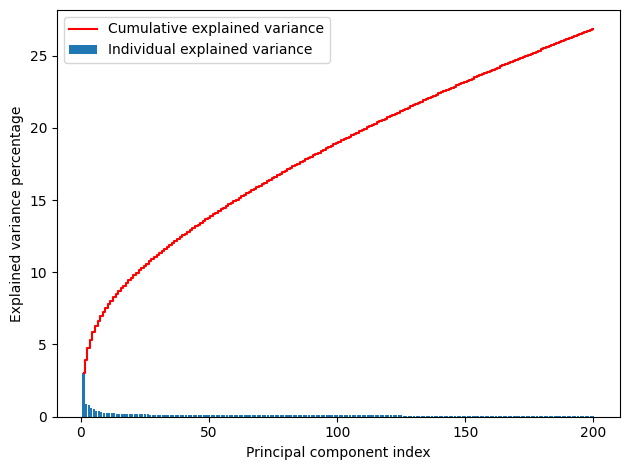

In [33]:
# apply PCA and evaluate explained variance

n_components = 200

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_flattened)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, n_components+1), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, n_components+1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(0, n_components+1, 50)))
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot_PCA.png")

In [34]:
# Separate two datasets from learning in order to create open test
X_ready = []
y_ready = []

X_ready = X_pca

#y_ready = y_binary
y_ready = y_generators

In [35]:
# Split between training, validation and test

split = 0.3

X_train, X_test, y_train, y_test = train_test_split(X_ready, y_ready, test_size=split, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(2730, 1170, 2730, 1170)

In [36]:
classification_models = [
      KNeighborsClassifier(),#(3),
      SVC(kernel='rbf'),
      DecisionTreeClassifier(),#max_depth=5),
      RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis()
      ]

scores = []
for model in classification_models:
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)
  model_name = type(model).__name__
  if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
  y_pred = model.predict(X_test)
  scores.append((
        model_name,
        (f'{100*f1_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*score:.2f}%'),
        (f'{matthews_corrcoef(y_test, y_pred):.2f}'),
        (f'{100*precision_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*recall_score(y_test, y_pred, average="macro"):.2f}%'),
        ))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','F1 Score','Accuracy','MCC','Precision','Recall'])
results = scores_df.sort_values(by='F1 Score',axis=0,ascending=False)
results

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,SVC RBF kernel,94.75%,92.56%,0.91,95.53%,94.10%
3,RandomForestClassifier,91.20%,87.78%,0.84,92.69%,89.96%
0,KNeighborsClassifier,90.04%,85.73%,0.82,91.53%,88.91%
2,DecisionTreeClassifier,83.99%,77.69%,0.72,85.03%,83.22%
5,GaussianNB,76.05%,70.00%,0.63,78.35%,75.78%
4,AdaBoostClassifier,58.84%,56.41%,0.47,66.19%,61.49%
6,QuadraticDiscriminantAnalysis,19.66%,48.21%,0.31,43.72%,23.88%
